In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# 📁 Gestion des fichiers et images
import os
import cv2
import numpy as np

# 🧪 Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 🔧 Modèle Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📊 Évaluation & visualisation


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay,
    roc_curve
)


2025-06-05 14:26:20.508323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749133580.799480      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749133580.882746      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Preprocessing**

In [2]:

# 📁 Load images and labels
data_dir = '/kaggle/input/socofing/SOCOFing'
images = []
labels = []

# 📂 "Real" Folder
real_path = os.path.join(data_dir, 'Real')
for root, _, files in os.walk(real_path):
    for file in files:
        if file.endswith('.BMP'):
            path = os.path.join(root, file)
            img = cv2.imread(path)
            img = cv2.resize(img, (64, 64))
            images.append(img)

            label = file.split('__')[0]
            labels.append(label)
            
# 🔍 Conversion to numpy arrays
X = np.array(images)
y = np.array(labels)

# Normalize
X = X.astype('float32') / 255.0

# 🎯 Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("📊 Nombre de classes uniques:", len(np.unique(y_encoded)))

# 🧠 One-hot encoding
y = to_categorical(y_encoded)

# 🔀 Separate into training / validation
# Train, Val, Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=np.argmax(y_temp, axis=1))


📊 Nombre de classes uniques: 600


**CNN architecture**

In [3]:

# Model construction
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])


# ⚙️ Compilation
model.compile(
    optimizer='adamax', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# 📄 Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-05 14:29:54.809632: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 600)                 │         154,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,427,352 (5.44 MB)

 Trainable params: 1,427,352 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

**data augmentation**

In [ ]:

# 📈 Generator creation with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    fill_mode='nearest'
)

# 🔥 Fit datagen on train images
datagen.fit(X_train)

**Model training**

In [4]:
#early stop
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    
)
# 📍 Set the path to save the best model
model_path = "/kaggle/working/final_good_model.keras"

# 💾 Callback to save the best model based on accuracy validation
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True, 
    mode='max', 
)
# 📉 Callback to reduce the learning rate if validation acc stable
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3, 
    verbose=1
)

In [ ]:
 #first training
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    initial_epoch=10,
   batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

In [ ]:
model.save("final_model_complete.keras")


In [5]:
model = load_model("/kaggle/input/my-final-model-2025/final_good_model.keras")


**Visualization**

In [ ]:

# 📈 Performance curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


![](https://i.postimg.cc/1zVx9MNV/courbes.png)


In [6]:
score1=model.evaluate(X_train,y_train)
print("error on training data : %.2f%%"% (score1[0]*100))
print("accuracy of training data : %.2f%%"% (score1[1]*100))

score=model.evaluate(X_test,y_test)
print("error on test data: %.2f%%"% (score[0]*100))
print("accuracy of test data: %.2f%%"% (score[1]*100))

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9985 - loss: 0.0051
error on training data : 0.82%
accuracy of training data : 99.70%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9976 - loss: 0.0054
error on test data: 0.47%
accuracy of test data: 99.83%


**Confusion Matrix**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


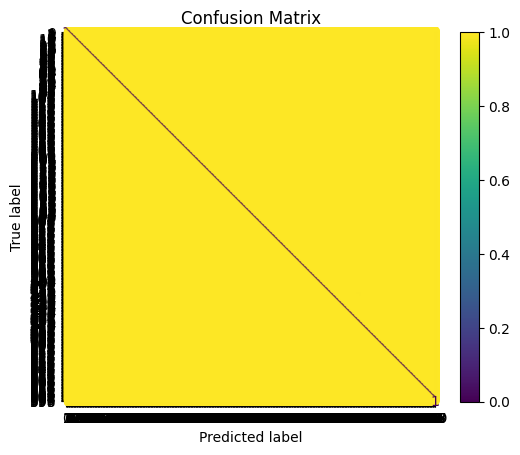

In [7]:

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


**Normalized Confusion Matrix**

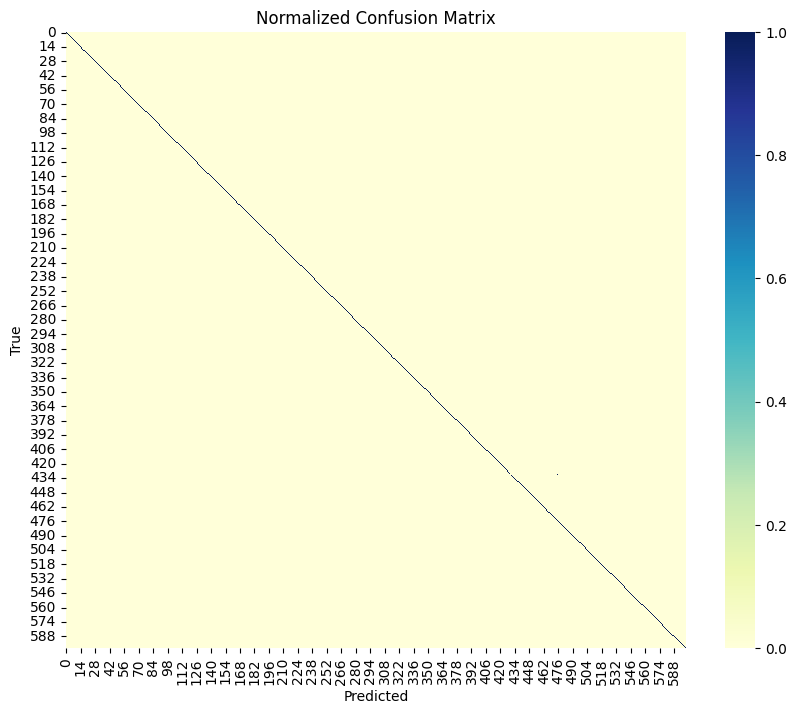

In [8]:


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=False, cmap="YlGnBu")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Error visualization**

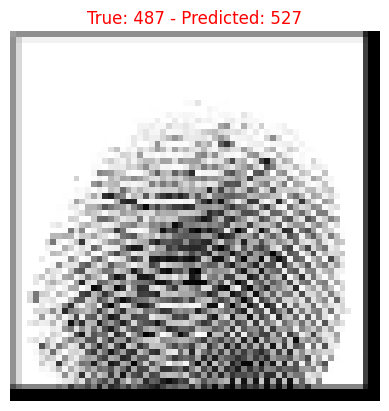

In [9]:
errors = np.where(y_pred != y_true)[0]

for i in range(min(5, len(errors))):
    idx = errors[i]
    plt.imshow(X_test[idx])
    true_label = le.inverse_transform([y_true[idx]])[0]
    pred_label = le.inverse_transform([y_pred[idx]])[0]
    plt.title(f"True: {true_label} - Predicted: {pred_label}",color="red")
    plt.axis("off")
    plt.show()



In [10]:
prediction = model.predict(X_test)
prediction1 = np.argmax(prediction,axis=1)
prediction1[:10]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array([155, 581, 317, 100, 583, 197, 423,  98, 118, 352])

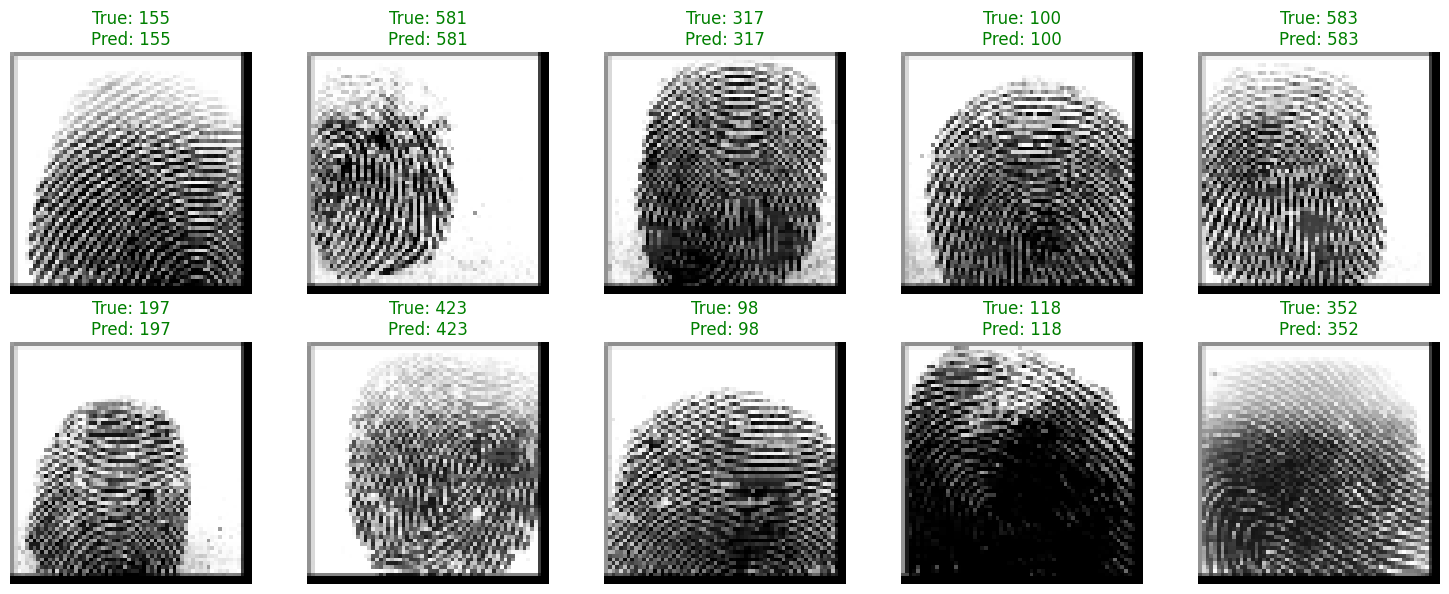

In [11]:

# Extract true labels
true_labels = np.argmax(y_test, axis=1)

# Show the first 10 photos
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title(f"True: {true_labels[i]}\nPred: {prediction1[i]}", color="green")
    plt.axis('off')
plt.tight_layout()
plt.show()


**predict a new image**

In [17]:
# 🔎 Enhanced function to predict and display one or more images

def predict_images(image_paths):
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    plt.figure(figsize=(18, 4))

    for i, image_path in enumerate(image_paths):
        if not os.path.exists(image_path):
            print(f"[❌] File not found: {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"[⚠️] Unable to load image: {image_path}")
            continue

        img_resized = cv2.resize(img, (64, 64)).astype('float32') / 255.0
        img_input = np.expand_dims(img_resized, axis=0)

        prediction = model.predict(img_input)
        class_index = np.argmax(prediction)
        class_label = le.inverse_transform([class_index])[0]

        true_label = int(os.path.basename(image_path).split('__')[0])

        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        color = "green" if class_label == true_label else "green"
        plt.title(f'Pred: {class_label}\nTrue: {true_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()





**Example of use for one image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


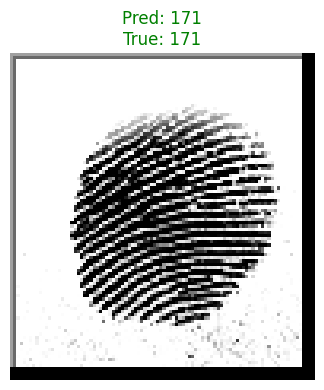

In [18]:
predict_images('/kaggle/input/socofing/SOCOFing/Real/171__M_Left_little_finger.BMP')


**Example of use for 6 images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


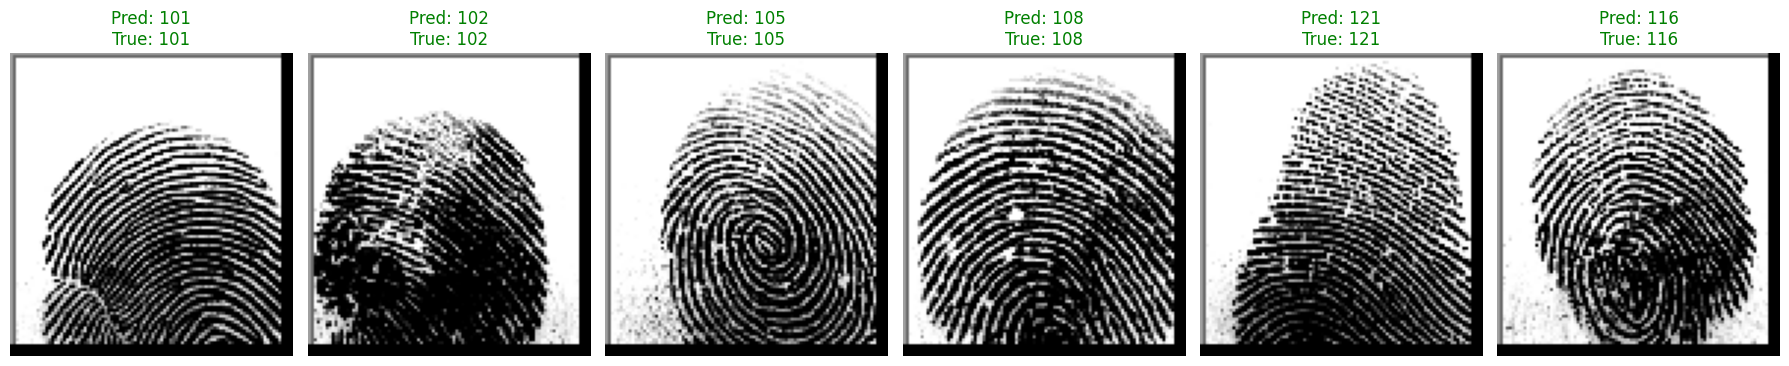

In [19]:
predict_images([
    '/kaggle/input/socofing/SOCOFing/Real/101__M_Right_middle_finger.BMP',
    '/kaggle/input/socofing/SOCOFing/Real/102__M_Right_index_finger.BMP',
    '/kaggle/input/socofing/SOCOFing/Real/105__M_Right_middle_finger.BMP',
    '/kaggle/input/socofing/SOCOFing/Real/108__M_Right_middle_finger.BMP',
    '/kaggle/input/socofing/SOCOFing/Real/121__F_Right_thumb_finger.BMP',
    '/kaggle/input/socofing/SOCOFing/Real/116__M_Right_little_finger.BMP',
])


**Test Accuracy after training**

In [20]:
model.load_weights("/kaggle/input/my-final-model-2025/final_model_complete.keras")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("✅ Test Accuracy:", test_acc)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9976 - loss: 0.0054
✅ Test Accuracy: 0.9983333349227905


**ROC, FAR, FRR, EER**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


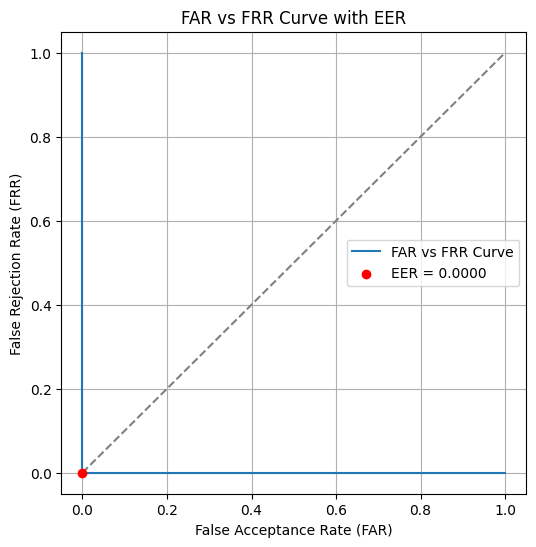

In [21]:


y_score = model.predict(X_test)

# Flatten labels and predictions
y_true_flat = y_test.ravel()
y_score_flat = y_score.ravel()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_flat, y_score_flat)

# FAR = FPR (False Positive Rate)
FAR = fpr

# FRR = 1 - TPR (False Rejection Rate)
FRR = 1 - tpr

# Find EER (Equal Error Rate)
eer_threshold = thresholds[np.nanargmin(np.absolute((FAR - FRR)))]
eer = FAR[np.nanargmin(np.absolute((FAR - FRR)))]

# Plot
plt.figure(figsize=(6, 6))
plt.plot(FAR, FRR, label='FAR vs FRR Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(eer, eer, color='red', label=f'EER = {eer:.4f}', zorder=5)
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.title("FAR vs FRR Curve with EER")
plt.legend()
plt.grid(True)
plt.show()


**ROC**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


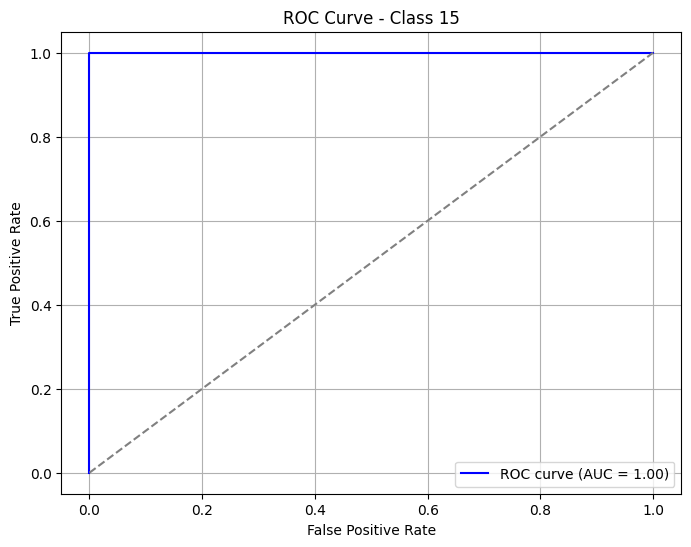

In [7]:
y_pred_proba = model.predict(X_test)

y_true = np.argmax(y_test, axis=1)

target_label = 15

# ROC: 1 vs rest
y_true_binary = (y_true == target_label).astype(int)
y_score_binary = y_pred_proba[:, target_label]

#  ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true_binary, y_score_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Class {target_label}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Precision-Recall Curves**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


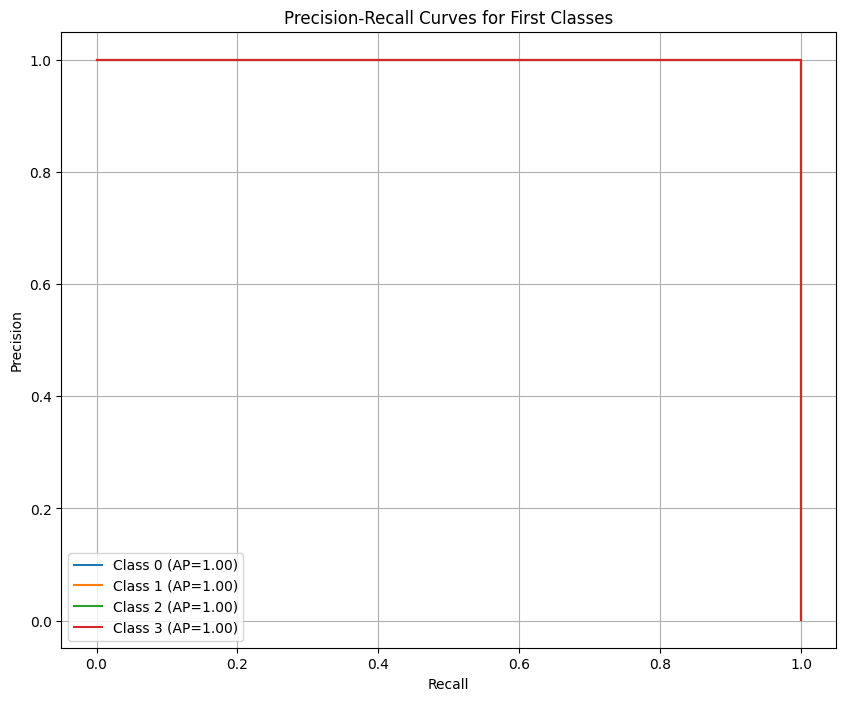

In [22]:
y_true_bin = y_test
y_scores = model.predict(X_test)
n_classes = y_true_bin.shape[1]

num_classes_to_plot = 4

plt.figure(figsize=(10, 8))
for i in range(num_classes_to_plot):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP={average_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for First Classes")
plt.legend()
plt.grid(True)
plt.show()
